In [24]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from networkx.algorithms import community
from networkx.algorithms import cluster
from networkx.generators import directed


import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas.io import sql
import glob
#import sqlalchemy as sqa
from datetime import date
from glob import glob
from pathlib import Path


from scipy.optimize import curve_fit 
%matplotlib inline

! mkdir -p ./networkx_graphs

In [25]:
def load_graph_data_by_year(graph_year, airports):
    print(f'Start loading international flights graph data for year - {graph_year}')
   
    filghts_path = f'./data/edges/international_source_target_count_week_14_per_year/flights_{graph_year}.csv'
    flights = pd.read_csv(filghts_path)
    G = nx.from_pandas_edgelist(flights,
                                source = 'Source',
                                target = 'Target',
                                edge_attr = 'flights_count',
                                create_using = nx.DiGraph())

    print(f'Adding attributes to graph nodes')    
    
    for index, row in airports.iterrows():
    # print(f'Adding Node ID - {row["airport_id"]}, Airport Name - {row["airport_name"]}')
        if row['airport_id'] in G.nodes():
            G.nodes[row['airport_id']]['airport_name'] = row['airport_name']
            G.nodes[row['airport_id']]['Country'] = row['country_name']
            G.nodes[row['airport_id']]['continent'] = row['continent_name']
            G.nodes[row['airport_id']]['airport_type'] = row['airport_type']
            G.nodes[row['airport_id']]['airport_lat'] = row['airport_lat']        
            G.nodes[row['airport_id']]['airport_lng'] = row['airport_lng']                
            G.nodes[row['airport_id']]['covid19_percentage'] = row['avg_cases_population_ratio_per_week_14']   
    return G
    
    
def persist_graph(G, year):
    print(f'Start persisting international flights graph data for year - {year}')
    print (nx.info(G))
    nx.draw(G, with_labels=True)
    print ('Degree Assortativity Coefficient (r): %s' % nx.degree_assortativity_coefficient(G))
    plt.show()
    nx.write_gexf(G,f'./networkx_graphs/international_flights_{year}.gexf')

    
    
    

Start loading international flights graph data for year - 2019
Adding attributes to graph nodes
Start persisting international flights graph data for year - 2019
Name: 
Type: DiGraph
Number of nodes: 1609
Number of edges: 15965
Average in degree:   9.9223
Average out degree:   9.9223
Degree Assortativity Coefficient (r): -0.1256401354683561


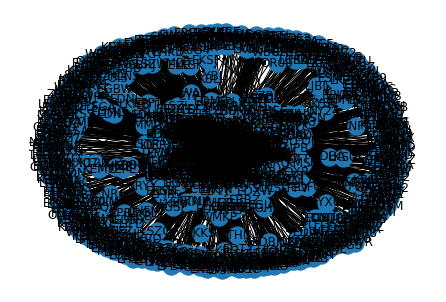

Start loading international flights graph data for year - 2020
Adding attributes to graph nodes
Start persisting international flights graph data for year - 2020
Name: 
Type: DiGraph
Number of nodes: 791
Number of edges: 4187
Average in degree:   5.2933
Average out degree:   5.2933
Degree Assortativity Coefficient (r): -0.03783458524365358


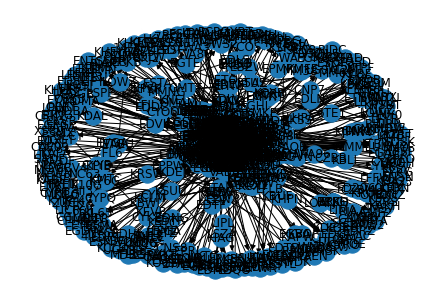

Start loading international flights graph data for year - 2021
Adding attributes to graph nodes
Start persisting international flights graph data for year - 2021
Name: 
Type: DiGraph
Number of nodes: 1295
Number of edges: 10264
Average in degree:   7.9259
Average out degree:   7.9259
Degree Assortativity Coefficient (r): -0.024784234576618602


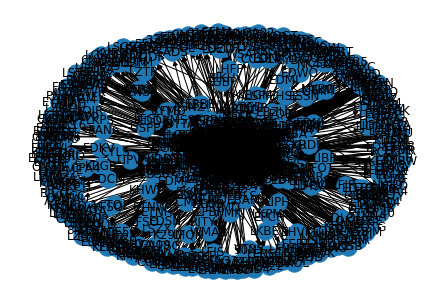

In [26]:
file_path = './data/dims/dim_airports.csv'
airports = pd.read_csv(file_path)

for year in list(['2019','2020','2021']):
    tmp_G = load_graph_data_by_year(graph_year = year, airports=airports)
    persist_graph(tmp_G,year)

# Degree, Average Degree and Degree Distribution

# Plot degree distribution

In [22]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Returns a list of the frequency of each degree value. In and out degree with weight"""
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree(G.nodes(),'weight'))
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree(G.nodes(),'weight'))
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree(G.nodes(),'weight')]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq
    
def plot_degree_distribution(G):# TODO wrap it in one function 
    in_degree_freq = degree_histogram_directed(G, in_degree=True)
    out_degree_freq = degree_histogram_directed(G, out_degree=True)
    degrees = range(len(in_degree_freq))
    plt.figure(figsize=(8, 8)) 
    plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'b.', label='in-degree')
    plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'r.', label='out-degree')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()


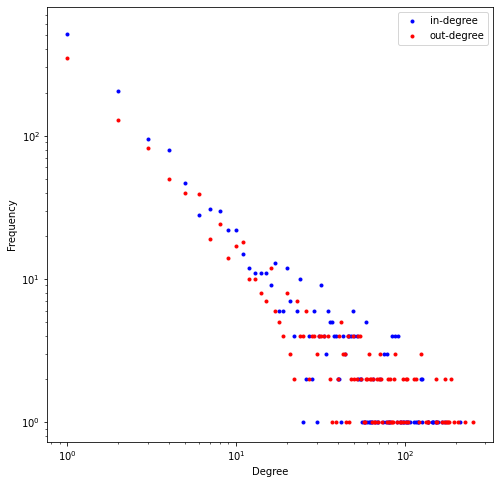

In [23]:
plot_degree_distribution(G)

### Plot knn as function of k

Fit function of the form:  $a\cdot X^{\mu}$

In [58]:
def plot_knn(G, fit=True): 
    knn_dict = nx.k_nearest_neighbors(G) # k_nearest_neighbors return dict with knn for each k
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,knn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('knn(k)')
    axes.set_title('Average next neighbor degree')
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()

# Plot snn as function of k

In [59]:
def plot_snn(G, fit=True): 
    snn_dict = nx.k_nearest_neighbors(G, weight='weight') 
    k_lst = sorted(snn_dict.keys())
    snn_lst = []
    for k in k_lst:
        snn_lst.append(snn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,snn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('snn(k)')
    axes.set_title('Average next neighbor strength')
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(snn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()

# Clustering coefficient for k
calculate C(k) the average clustering coefficient for nodes with degree k.

In [60]:
def plot_clustering_coefficient(G):
    clustering_dict = {}
    for node in G.nodes():
        k = G.degree(node)
        if not k in clustering_dict:
            clustering_dict[k] = [nx.clustering(G,node)]
        else:
            clustering_dict[k].append(nx.clustering(G,node))
    k_lst = sorted(clustering_dict.keys())
    clustering_lst = []
    for k in k_lst:
        clustering_lst.append(np.array(clustering_dict[k]).mean())
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,clustering_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title('Average clustering coefficient')
    
    plt.show()

We will wrap the attributes from above and the plots in a function for our convenience

In [62]:
def print_attributes_and_plots(G):
    print (nx.info(G))
    if not nx.is_directed(G):
        if nx.is_connected(G):
            print ('Diameter: %s' % nx.diameter(G)) # print diameter of the network
        else:
            print ('Graph not connected: infinite path length')
            print ('Size of largest component: %s' % len(max(nx.connected_components(G), key=len)))
    print ('Degree Assortativity Coefficient (r): %s' % nx.degree_assortativity_coefficient(G))
    plot_degree_dist(G)
    plot_knn(G, fit=False)
    if not nx.is_directed(G):
        plot_clustering_coefficient(G)

Name: 
Type: DiGraph
Number of nodes: 8203
Number of edges: 59985
Average in degree:   7.3126
Average out degree:   7.3126
Degree Assortativity Coefficient (r): 0.10011838331936061


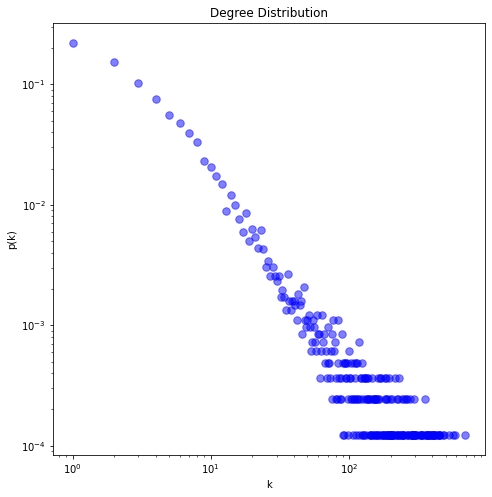

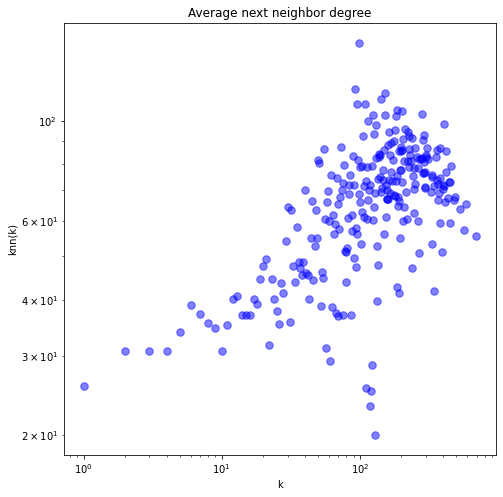

In [63]:
print_attributes_and_plots(G)

### N(t) and L(t)

In [120]:
n_nodes =[]
n_edges = []
time_scale = []
for time in sorted(times):
    time_scale.append(time)
    n_nodes.append(graphs[time].number_of_nodes())
    n_edges.append(graphs[time].number_of_edges())

In [121]:
plt.rcParams.update({'font.size': 20, 'figure.figsize': (6, 4)})

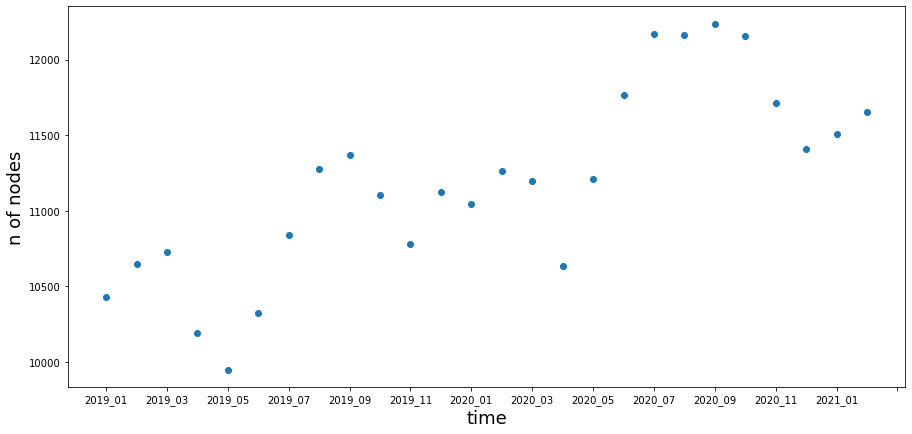

In [122]:
plt.figure(figsize=(15, 7)) 
plt.scatter(time_scale[1:],n_nodes[1:], label='n of nodes vs time')
plt.xlabel('time',fontsize=18)
plt.ylabel('n of nodes',fontsize=18)
plt.xticks(np.arange(0, len(time_scale), 2),fontsize=10)
plt.yticks(fontsize=10)
plt.show()

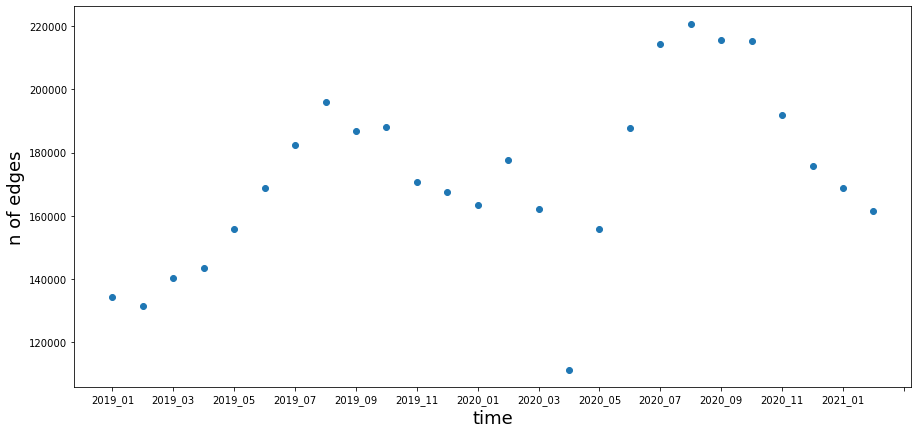

In [123]:
plt.figure(figsize=(15, 7)) 
plt.scatter(time_scale[1:],n_edges[1:], label='n of nodes vs time')
plt.xlabel('time',fontsize=18)
plt.ylabel('n of edges',fontsize=18)
plt.xticks(np.arange(0, len(time_scale), 2),fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Decided to look on month with highest and lowest n of nodes

In [124]:
G19_05 = graphs['2019_05']
G19_09 = graphs['2019_09']
G20_04 = graphs['2020_04']
G20_08 = graphs['2020_08']

In [125]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Returns a list of the frequency of each degree value. In and out degree with weight"""
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree(G.nodes(),'weight'))
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree(G.nodes(),'weight'))
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree(G.nodes(),'weight')]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq


def plot_degree_distribution(G):# TODO wrap it in one function 
    in_degree_freq = degree_histogram_directed(G, in_degree=True)
    out_degree_freq = degree_histogram_directed(G, out_degree=True)
    degrees = range(len(in_degree_freq))
    plt.figure(figsize=(8, 8)) 
    plt.loglog(range(len(in_degree_freq)), in_degree_freq, 'b.', label='in-degree')
    plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'r.', label='out-degree')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()
   
    """ 
    plt.figure(figsize=(8, 8)) 
    plt.loglog(range(len(out_degree_freq)), out_degree_freq, 'r.', label='out-degree')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()
    """

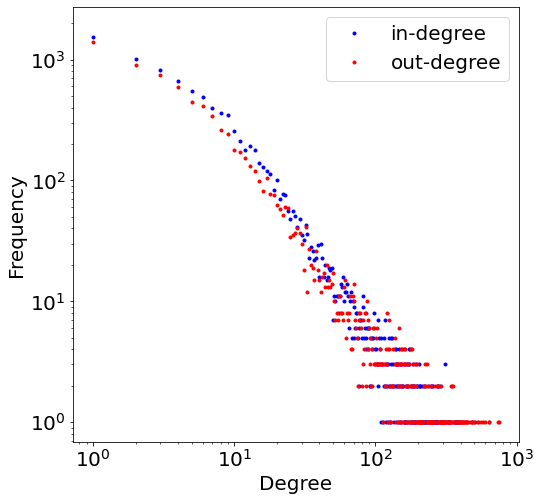

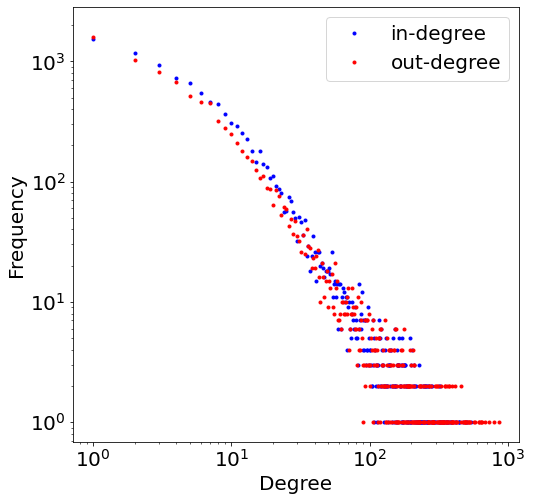

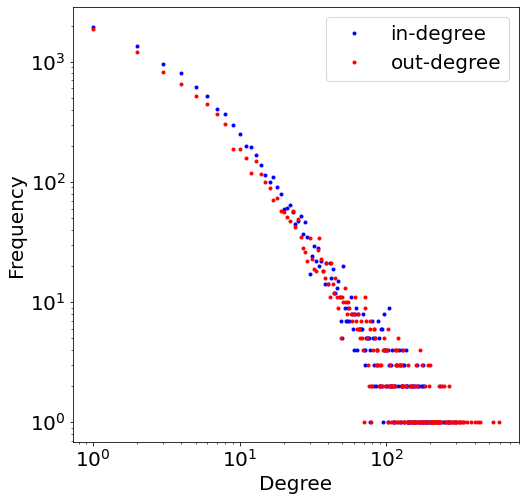

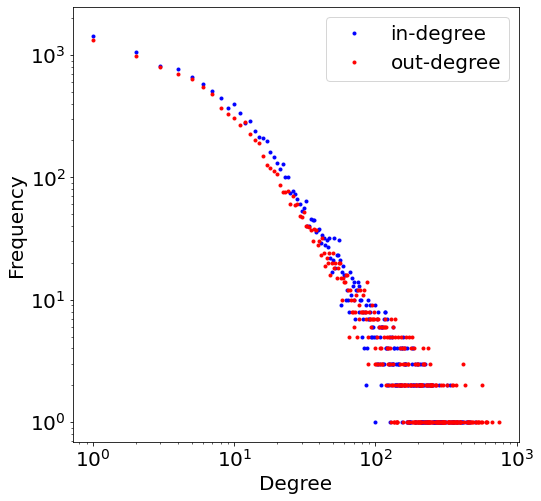

In [126]:
plot_degree_distribution(G19_05)
plot_degree_distribution(G19_09)
plot_degree_distribution(G20_04)
plot_degree_distribution(G20_08)

In [127]:
def average_degree_directed(G):
    in_degree = dict(G.in_degree(G.nodes()))
    out_degree = dict(G.out_degree(G.nodes()))
    degseq1=[in_degree.get(k,0) for k in G.nodes()]
    degseq2=[out_degree.get(k,0) for k in G.nodes()]
    d_in = sum(degseq1)/len(degseq1)
    d_out = sum(degseq2)/len(degseq2)
    return d_in, d_out

In [128]:
avg_in_degree ,avg_out_degree = average_degree_directed(G19_05)

In [129]:
avg_weight = 0
for outn,inn,weight in G19_05.edges.data("weight"):
    avg_weight += weight
avg_weight = avg_weight/ G.number_of_edges()

TypeError: unsupported operand type(s) for +=: 'int' and 'NoneType'

In [ ]:
avg_in_degree ,avg_out_degree ,avg_weight

## Centralitry 

In [1]:
#my computer not able to calculate it in reasonable time - maybe the network is too big
"""from networkx.algorithms.centrality import betweenness_centrality
betw_c = betweenness_centrality(G19_09, weight='weight')"""

"from networkx.algorithms.centrality import betweenness_centrality\nbetw_c = betweenness_centrality(G19_09, weight='weight')"

In [ ]:
from networkx.algorithms.centrality import eigenvector_centrality
eig_cent = eigenvector_centrality(G19_09, max_iter=800, weight='weight')

In [ ]:
cent_id = []
cent_n = []
for k, v in sorted(eig_cent.items(), key=lambda item: item[1],reverse = True):
        cent_id.append(k)
        cent_n.append(v)

In [ ]:
cent_n[:16]

In [ ]:
for ids in cent_id[:16]:
    print(airports.loc[airports['ident']==ids][["name","iso_country"]])

In [131]:
in_centr = nx.in_degree_centrality(G19_09)
out_centr = nx.out_degree_centrality(G19_09)

In [132]:
def high_centr(centr):
    central_id = []
    central_n = []
    for k, v in sorted(centr.items(), key=lambda item: item[1],reverse = True):
        central_id.append(k)
        central_n.append(v)
    return central_id, central_n

In [133]:
central_out_id,central_out_n = high_centr(out_centr )
central_in_id,central_in_n = high_centr(in_centr )

Checking what countries have highest centrality 

In [ ]:
file_path = Path('./data/airports.csv')
airports = pd.read_csv(file_path)

In [136]:

for ids in central_out_id[:20]:
    print(airports.loc[airports['ident']==ids][["name","iso_country"]])
    

                                       name iso_country
32709  Chicago O'Hare International Airport          US
                    name iso_country
34434  Teterboro Airport          US
                                          name iso_country
31909  Washington Dulles International Airport          US
                                          name iso_country
30868  Dallas Fort Worth International Airport          US
                                     name iso_country
32889  Philadelphia International Airport          US
                                          name iso_country
30720  Charlotte Douglas International Airport          US
                                                   name iso_country
30432  Hartsfield Jackson Atlanta International Airport          US
                             name iso_country
31816  Westchester County Airport          US
                                       name iso_country
32327  Chicago Midway International Airport          US
            

## Clustering coef comparison with random network

In [137]:
from networkx.generators.random_graphs import gnm_random_graph

Network preserving n of nodes and edges

In [138]:
random_G = gnm_random_graph(G19_05.number_of_nodes(), G19_05.number_of_edges(), seed=42, directed=True)

In [139]:
nx.average_clustering(G19_05)

0.3357914088188189

In [140]:
nx.average_clustering(random_G)

0.0015965483559829297

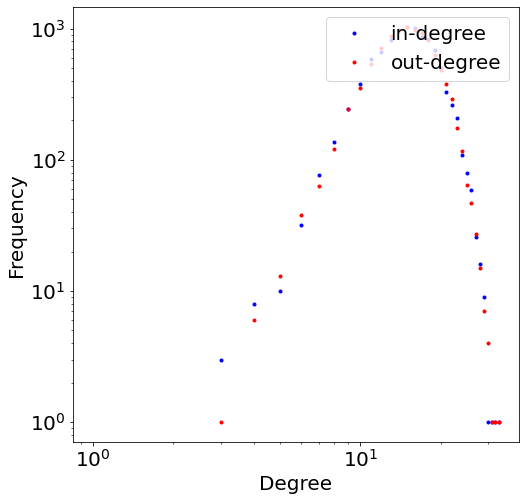

In [141]:
plot_degree_distribution(random_G)

### Knn and Snn

In [142]:
def fit_func(x,a,mu):
    return a*x**mu

def plot_knn(G,s = 'in+out',t = 'in+out',fit=True, title = 'Average next neighbour degree'): 
    knn_dict = nx.k_nearest_neighbors(G, source=s, target=t)
    #knn_dict = nx.k_nearest_neighbors(G) # k_nearest_neighbors return dict with knn for each k
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,knn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('knn(k)')
    axes.set_title(title)
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    plt.show()
    print(popt)
    
def plot_snn(G,s = 'in+out',t = 'in+out',fit=True, title = 'Average next neighbour degree'):
    snn_dict = nx.k_nearest_neighbors(G, source=s, target=t,weight='Weight') 
    k_lst = sorted(snn_dict.keys())
    snn_lst = []
    for k in k_lst:
        snn_lst.append(snn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,snn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('snn(k)')
    axes.set_title(title)
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(snn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()
    print(popt)
    
    

In [143]:
def knn(G,f = True):
    plot_knn(G,s = 'in',t = 'out',fit = f,title = 'Average next neighbour degree in-out')
    plot_knn(G,s = 'out',t = 'in',fit = f, title = 'Average next neighbour degree out-in')
    plot_knn(G,s = 'in',t = 'in',fit = f, title = 'Average next neighbour degree in-in')
    plot_knn(G,s = 'out',t = 'out',fit = f, title = 'Average next neighbour degree out-out')

In [153]:
def snn(G,f = True):
    plot_snn(G,s = 'out',t = 'in',fit = f, title = 'Average next neighbour degree in-out')
    plot_snn(G,s = 'out',t = 'in',fit = f, title = 'Average next neighbour degree out-in')
    plot_snn(G,s = 'in',t = 'in',fit =f, title = 'Average next neighbour degree in-in')
    plot_snn(G,s = 'out',t = 'out',fit = f, title = 'Average next neighbour degree out-out')

In [145]:
from networkx.algorithms.assortativity import degree_assortativity_coefficient

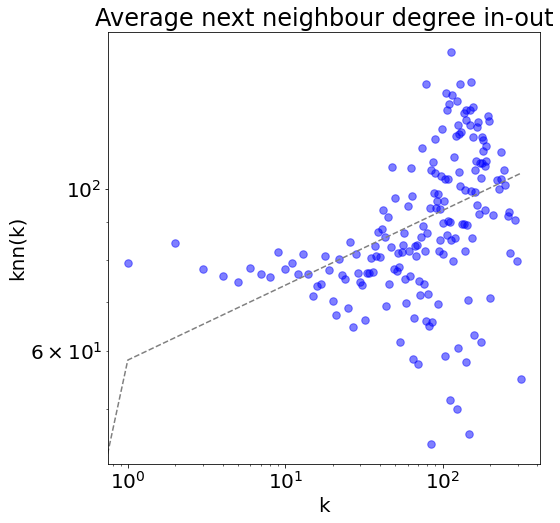

[58.28678694  0.10248976]


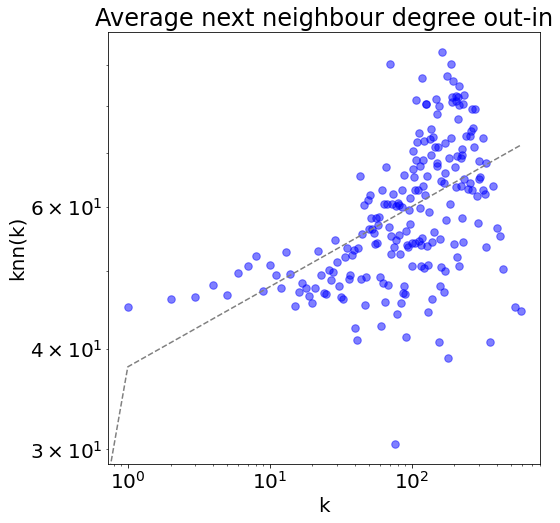

[37.97923937  0.09931232]


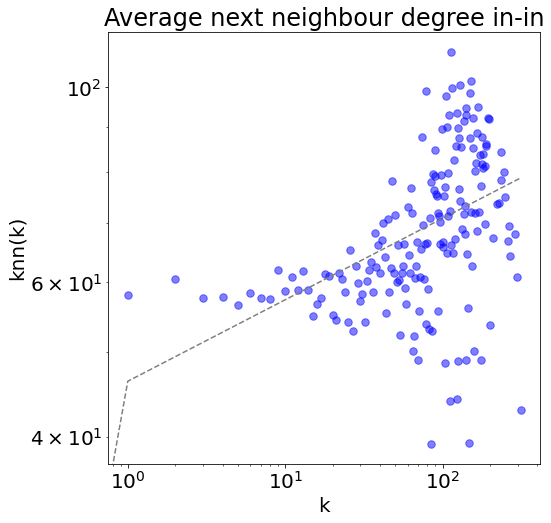

[46.27105184  0.09268297]


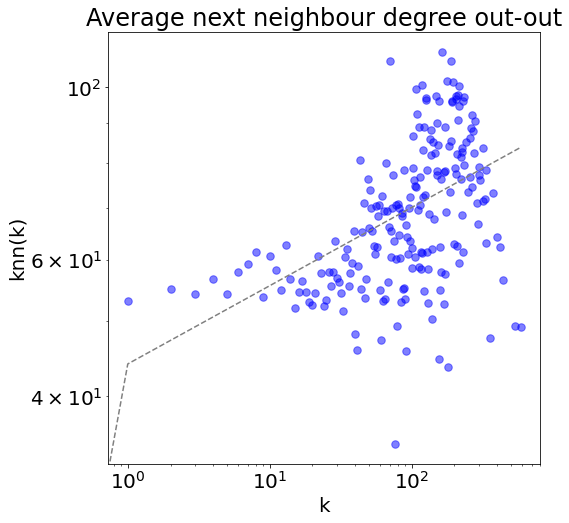

[44.04612875  0.10076019]


In [183]:
knn(graphs['2020_04'])

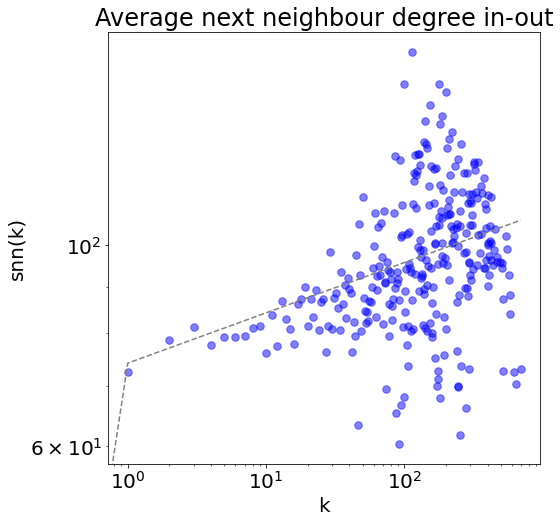

[7.41079698e+01 5.55173505e-02]


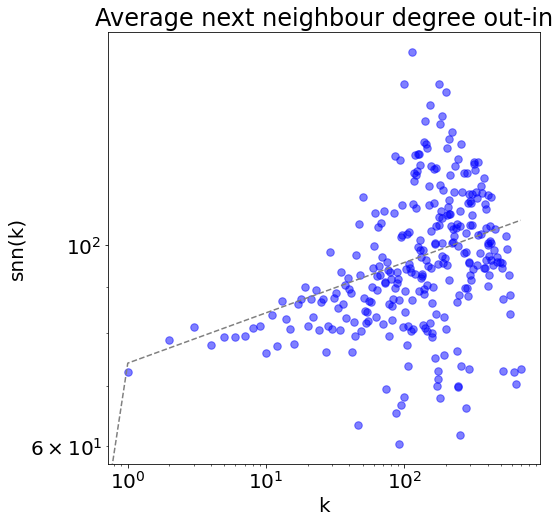

[7.41079698e+01 5.55173505e-02]


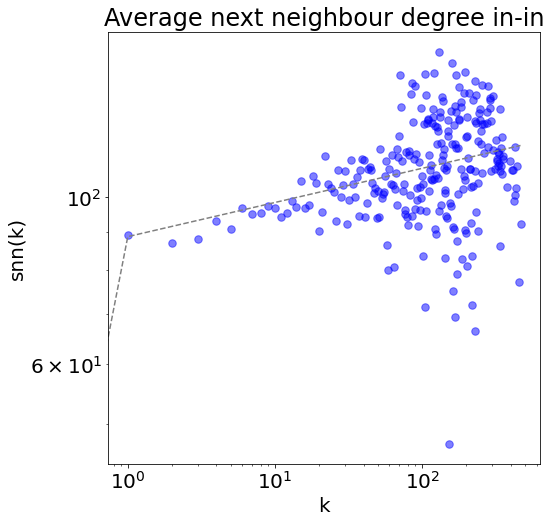

[8.86490216e+01 4.53291162e-02]


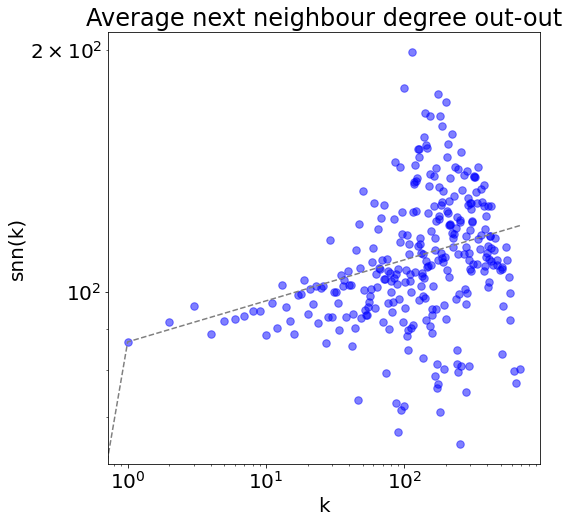

[8.66693984e+01 5.09734463e-02]


In [191]:
snn(graphs['2020_12'])

### Hierarchy

In [73]:
def plot_clustering_coefficient(G):
    clustering_dict = {}
    for node in G.nodes():
        k = G.degree(node)
        if not k in clustering_dict:
            clustering_dict[k] = [nx.clustering(G,node)]
        else:
            clustering_dict[k].append(nx.clustering(G,node))
    k_lst = sorted(clustering_dict.keys())
    clustering_lst = []
    for k in k_lst:
        clustering_lst.append(np.array(clustering_dict[k]).mean())
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,clustering_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title('Average clustering coefficient')
    
    plt.show()

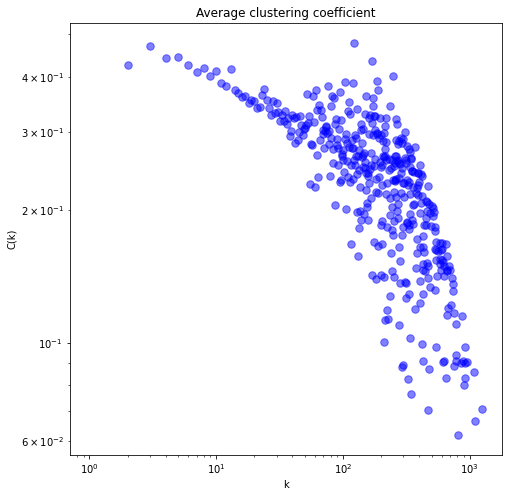

In [74]:
 plot_clustering_coefficient(G19_05)